In [ ]:
import matplotlib.pyplot as plt
import os.path
import numpy as np
import sys
import pickle
import time
sys.path.append('../..')

import Helpers
from Helpers.NeuralNetwork import NeuralNetwork

from Data import DatasetClasses

from Layers.FullyConnected import FullyConnected
from Layers.Activations import SoftMax
from Layers.Flatten import Flatten
from Layers.ReLU import ReLU
from Layers.Base import BaseLayer
from Layers.RandomForestLayer import RandomForestLayer
from Layers.Initializers import He, Constant, UniformRandom

from Optimization.Optimizers import Sgd
from Optimization.Loss import CrossEntropyLoss
from Optimization.Constraints import L2_Regularizer

### Dataset


dataset Informations:
--------------------------------------------------
Training samples: 1168
Sample shape: (1, 8, 8)
Number of classes: 10
Test samples: 360
Dataset size in memory: 0.75 MB


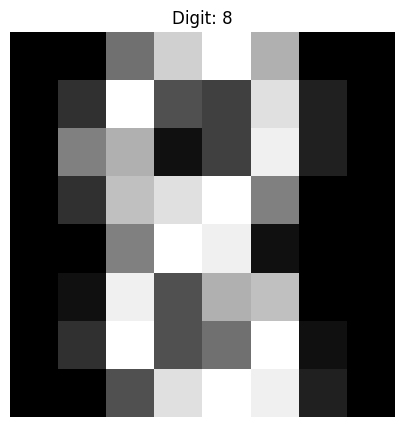

In [6]:
batch_size = 100
digitdata = DatasetClasses.DigitData(batch_size)
digitdata.print_dataset_info()

# Fondements Mathématiques du Random Forest

## Principe de l'Ensemble

Un Random Forest combine **N** arbres de décision indépendants par vote majoritaire :

$$\hat{y} = \text{mode}\{h_1(\mathbf{x}), h_2(\mathbf{x}), \ldots, h_N(\mathbf{x})\}$$

où $h_i(\mathbf{x})$ représente la prédiction du $i$-ème arbre pour l'observation $\mathbf{x}$.

## Mesure d'Impureté

L'entropie d'un nœud contenant des échantillons de classes $\{c_1, c_2, \ldots, c_K\}$ :

$$H(S) = -\sum_{i=1}^{K} p_i \log_2(p_i)$$

où $p_i = \frac{|S_i|}{|S|}$ est la proportion d'échantillons de classe $i$ dans le nœud $S$.

## Critère de Division

Le gain d'information pour un split sur la variable $j$ avec seuil $t$ :

$$\text{Gain}(S, j, t) = H(S) - \frac{|S_L|}{|S|}H(S_L) - \frac{|S_R|}{|S|}H(S_R)$$

avec :
- $S_L = \{(\mathbf{x}, y) \in S : x_j \leq t\}$ (partition gauche)
- $S_R = \{(\mathbf{x}, y) \in S : x_j > t\}$ (partition droite)

Le meilleur split maximise ce gain : $(j^*, t^*) = \arg\max_{j,t} \text{Gain}(S, j, t)$

## Randomisation des Variables

À chaque nœud, seules $m$ variables sont considérées parmi les $p$ disponibles :
- **Classification** : $m = \sqrt{p}$
- **Régression** : $m = \frac{p}{3}$

Cette sélection aléatoire décolle les arbres et réduit la variance de l'ensemble.

## Bootstrap Aggregating

Chaque arbre $h_i$ est entraîné sur un échantillon bootstrap $S_i$ de taille $n$ :

$$S_i = \{(\mathbf{x}_{j_1}, y_{j_1}), (\mathbf{x}_{j_2}, y_{j_2}), \ldots, (\mathbf{x}_{j_n}, y_{j_n})\}$$

où chaque indice $j_k$ est tiré uniformément avec remise dans $\{1, 2, \ldots, n\}$.

## Réduction de la Variance

Soit $\sigma^2$ la variance d'un arbre individuel et $\rho$ la corrélation moyenne entre arbres. La variance de l'ensemble est :

$$\text{Var}(\text{Random Forest}) = \rho \sigma^2 + \frac{1-\rho}{N} \sigma^2$$

Le Random Forest réduit la variance en diminuant $\rho$ (randomisation) et en augmentant $N$ (nombre d'arbres).

=== Test SimpleDecisionTree ===

Dataset créé: 100 échantillons, 2 features
Classes: (array([0, 1]), array([52, 48]))

--- Test 1: Arbre de décision simple ---
✅ Arbre entraîné avec succès
Précision sur données d'entraînement: 0.560

--- Test 2: Structure de l'arbre ---
Root: Feature 1 <= -1.763
  ├─L: LEAF -> Classe 0
  └─R: Feature 0 <= 1.478
    ├─L: Feature 0 <= 1.143
      ├─L: LEAF -> Classe 1
      └─R: LEAF -> Classe 0
    └─R: LEAF -> Classe 1

--- Test 3: Impact de la profondeur ---
Profondeur  1: Précision = 0.520
Profondeur  2: Précision = 0.550
Profondeur  3: Précision = 0.560
Profondeur  5: Précision = 0.690
Profondeur 10: Précision = 1.000

--- Test 4: Visualisation des données ---


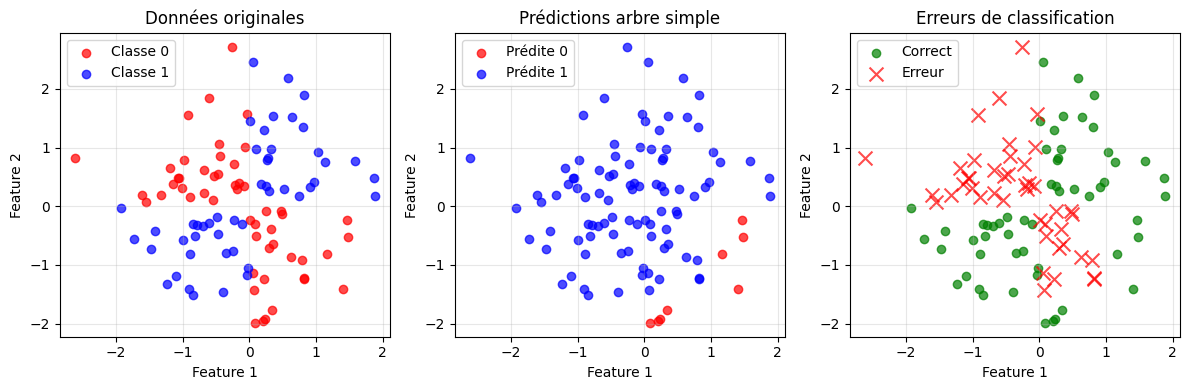


--- Test 5: Calculs d'entropie ---
Entropie initiale: 0.999
Entropie classe 0: -0.000 (52 échantillons)
Entropie classe 1: -0.000 (48 échantillons)

🎉 Tests SimpleDecisionTree terminés avec succès!


In [ ]:
# Créer des données de test simples (dataset XOR modifié)
print("=== Test SimpleDecisionTree ===\n")

# Générer des données synthétiques simples
np.random.seed(42)
n_samples = 100

# Créer un dataset simple avec 2 features
X_simple = np.random.randn(n_samples, 2)
# Créer des labels basés sur une règle simple
y_simple = ((X_simple[:, 0] > 0) & (X_simple[:, 1] > 0)).astype(int) + \
           ((X_simple[:, 0] < 0) & (X_simple[:, 1] < 0)).astype(int)

print(f"Dataset créé: {n_samples} échantillons, 2 features")
print(f"Classes: {np.unique(y_simple, return_counts=True)}")

# Test 1: Créer et entraîner un arbre simple
print("\n--- Test 1: Arbre de décision simple ---")
tree = RandomForestLayer.SimpleDecisionTree(max_depth=3, min_samples_split=5)

# Entraîner l'arbre
tree.fit(X_simple, y_simple)
print("✅ Arbre entraîné avec succès")

# Faire des prédictions
predictions = tree.predict(X_simple)
accuracy = np.mean(predictions == y_simple)
print(f"Précision sur données d'entraînement: {accuracy:.3f}")

# Test 2: Analyser la structure de l'arbre
print("\n--- Test 2: Structure de l'arbre ---")
def print_tree_structure(node, depth=0, prefix="Root"):
    indent = "  " * depth
    if 'class' in node:
        print(f"{indent}{prefix}: LEAF -> Classe {node['class']}")
    else:
        print(f"{indent}{prefix}: Feature {node['feature']} <= {node['threshold']:.3f}")
        print_tree_structure(node['left'], depth+1, "├─L")
        print_tree_structure(node['right'], depth+1, "└─R")

print_tree_structure(tree.tree)

# Test 3: Comparer différentes profondeurs
print("\n--- Test 3: Impact de la profondeur ---")
depths = [1, 2, 3, 5, 10]
for depth in depths:
    tree_test = RandomForestLayer.SimpleDecisionTree(max_depth=depth, min_samples_split=5)
    tree_test.fit(X_simple, y_simple)
    pred = tree_test.predict(X_simple)
    acc = np.mean(pred == y_simple)
    print(f"Profondeur {depth:2d}: Précision = {acc:.3f}")

# Test 4: Visualisation des prédictions
print("\n--- Test 4: Visualisation des données ---")
plt.figure(figsize=(12, 4))

# Subplot 1: Données originales
plt.subplot(1, 3, 1)
colors = ['red', 'blue', 'green']
for i in range(len(np.unique(y_simple))):
    mask = y_simple == i
    plt.scatter(X_simple[mask, 0], X_simple[mask, 1], 
               c=colors[i], label=f'Classe {i}', alpha=0.7)
plt.title('Données originales')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Prédictions de l'arbre
plt.subplot(1, 3, 2)
for i in range(len(np.unique(predictions))):
    mask = predictions == i
    plt.scatter(X_simple[mask, 0], X_simple[mask, 1], 
               c=colors[i], label=f'Prédite {i}', alpha=0.7)
plt.title('Prédictions arbre simple')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Erreurs
plt.subplot(1, 3, 3)
correct = predictions == y_simple
plt.scatter(X_simple[correct, 0], X_simple[correct, 1], 
           c='green', label='Correct', alpha=0.7, marker='o')
plt.scatter(X_simple[~correct, 0], X_simple[~correct, 1], 
           c='red', label='Erreur', alpha=0.7, marker='x', s=100)
plt.title('Erreurs de classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test 5: Entropie et gain d'information
print("\n--- Test 5: Calculs d'entropie ---")
print(f"Entropie initiale: {tree._entropy(y_simple):.3f}")

# Calculer l'entropie pour chaque classe
for class_label in np.unique(y_simple):
    mask = y_simple == class_label
    class_entropy = tree._entropy(y_simple[mask])
    print(f"Entropie classe {class_label}: {class_entropy:.3f} ({np.sum(mask)} échantillons)")

### Architecture: Random Forest Classifier

In [7]:
def build_random_forest_classifier(n_trees=10, max_depth=5, min_samples_split=10, max_features=None, num_classes=10, random_state=42):
    """
    Build a Random Forest classifier using the neural network architecture
    """
    # Create a dummy optimizer (not used for Random Forest)
    optimizer = Sgd(0.01)
    weights_initializer = He()
    bias_initializer = Constant(0.0)
    
    # Initialize network
    net = NeuralNetwork(optimizer, weights_initializer, bias_initializer)
    
    # Add layers
    net.append_layer(Flatten())  # Flatten input to vector
    net.append_layer(RandomForestLayer(
        n_trees=n_trees,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        num_classes=num_classes,
        random_state=random_state
    ))
    
    return net

### Train and Test Random Forest Model

Created Random Forest model with 10 trees, max_depth=6


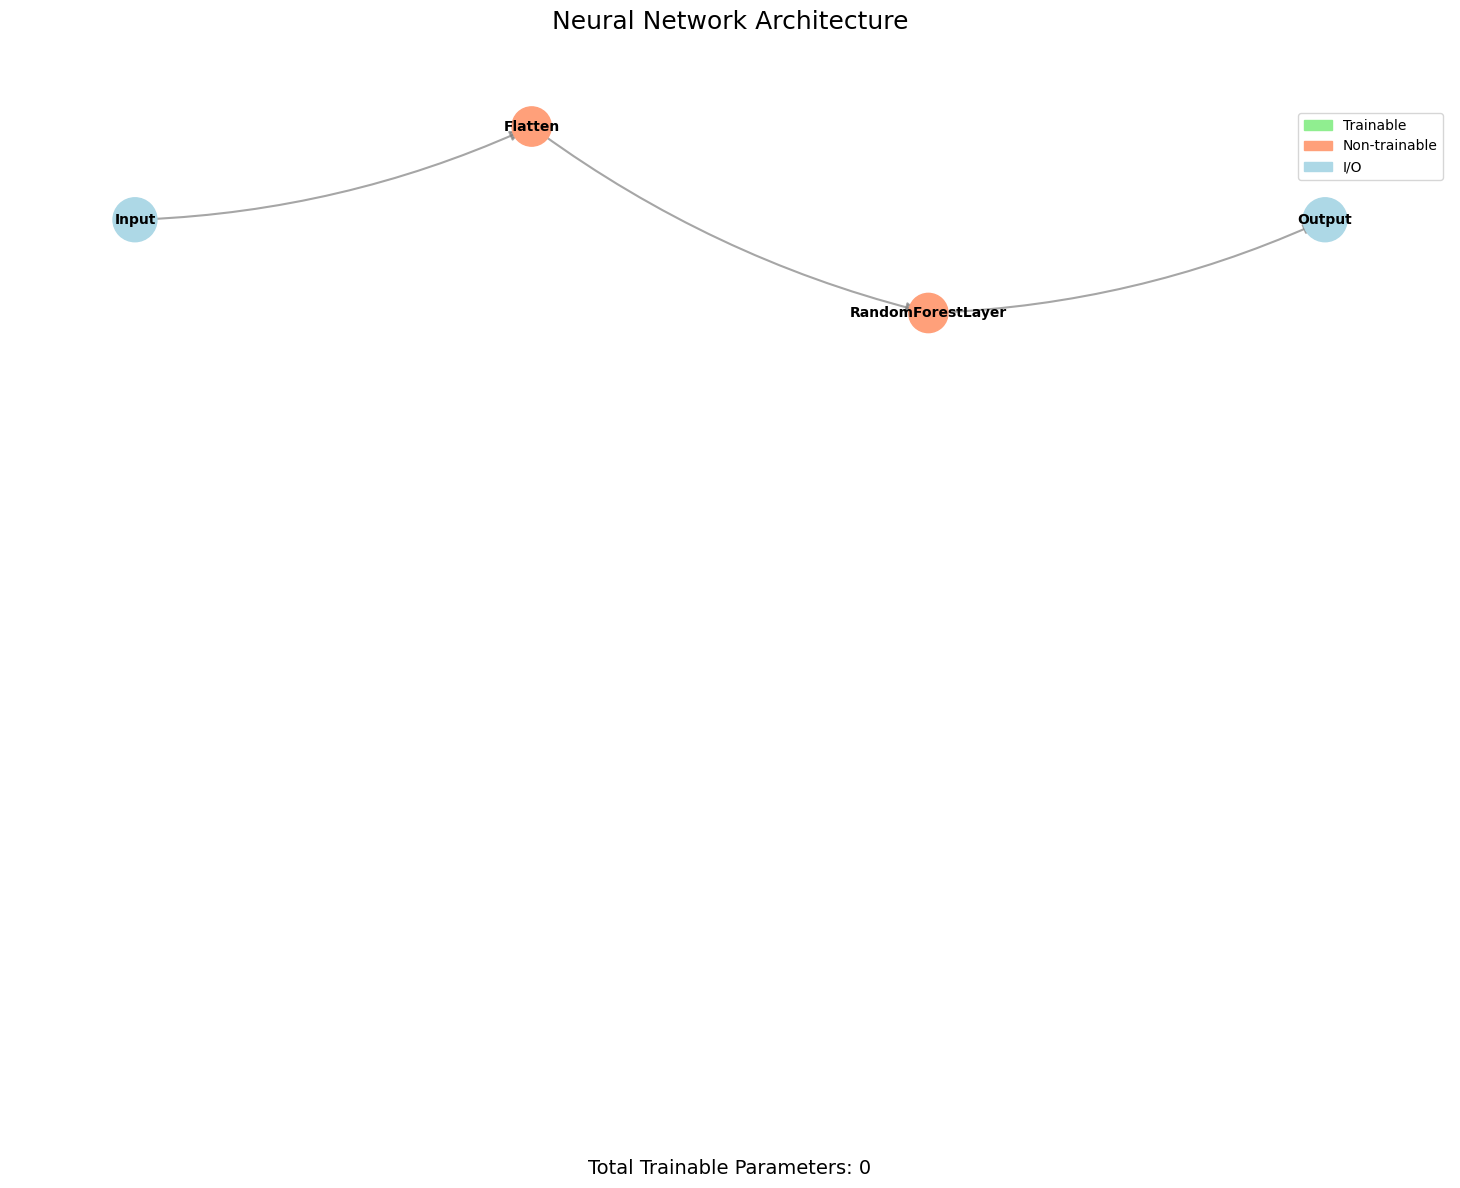

Training Random Forest with 1000 training samples...
Trained 10 trees successfully


In [8]:
# Build Random Forest classifier
n_trees = 10
max_depth = 6
net = build_random_forest_classifier(n_trees=n_trees, max_depth=max_depth, num_classes=10)
net.data_layer = digitdata
print(f"Created Random Forest model with {n_trees} trees, max_depth={max_depth}")

# Visualize the network
fig = net.plot()

# Get training data and store it in the Random Forest layer
train_data, train_labels_onehot = digitdata.get_train_set()
# Convert one-hot labels to integer labels
train_labels = np.argmax(train_labels_onehot, axis=1)

rf_layer = net.layers[1]  # The Random Forest layer

# Use a subset of training data for faster computation
subset_size = 1000  # Use 1000 training samples
indices = np.random.choice(len(train_data), subset_size, replace=False)
train_subset = train_data[indices].reshape(subset_size, -1)
labels_subset = train_labels[indices]

# Train the Random Forest (this happens automatically when storing data)
rf_layer.store_training_data(train_subset, labels_subset)

### Evaluate on Test Set

In [9]:
# Get the test set
test_data, test_labels_onehot = net.data_layer.get_test_set()
# Convert one-hot labels to integer labels
test_labels = np.argmax(test_labels_onehot, axis=1)

# Test the network on the test set
results = net.test(test_data)
predicted_classes = np.argmax(results, axis=1)
accuracy = np.mean(predicted_classes == test_labels)

print(f'\nOn the digits dataset, Random Forest ({n_trees} trees) achieves an accuracy of: {accuracy * 100:.2f}%')


On the digits dataset, Random Forest (10 trees) achieves an accuracy of: 87.22%


### Analysis with Different Number of Trees

Testing different numbers of trees...

Testing n_trees=1...
Training Random Forest with 1000 training samples...
Trained 1 trees successfully
  Accuracy: 0.6833, Training time: 0.46s
Testing n_trees=3...
Training Random Forest with 1000 training samples...
Trained 3 trees successfully
  Accuracy: 0.7333, Training time: 1.09s
Testing n_trees=5...
Training Random Forest with 1000 training samples...
Trained 5 trees successfully
  Accuracy: 0.8000, Training time: 2.10s
Testing n_trees=10...
Training Random Forest with 1000 training samples...
Trained 10 trees successfully
  Accuracy: 0.8767, Training time: 4.55s
Testing n_trees=15...
Training Random Forest with 1000 training samples...
Trained 15 trees successfully
  Accuracy: 0.8967, Training time: 6.01s
Testing n_trees=20...
Training Random Forest with 1000 training samples...
Trained 20 trees successfully
  Accuracy: 0.9200, Training time: 8.35s
Testing n_trees=30...
Training Random Forest with 1000 training samples...
Trained 30 trees

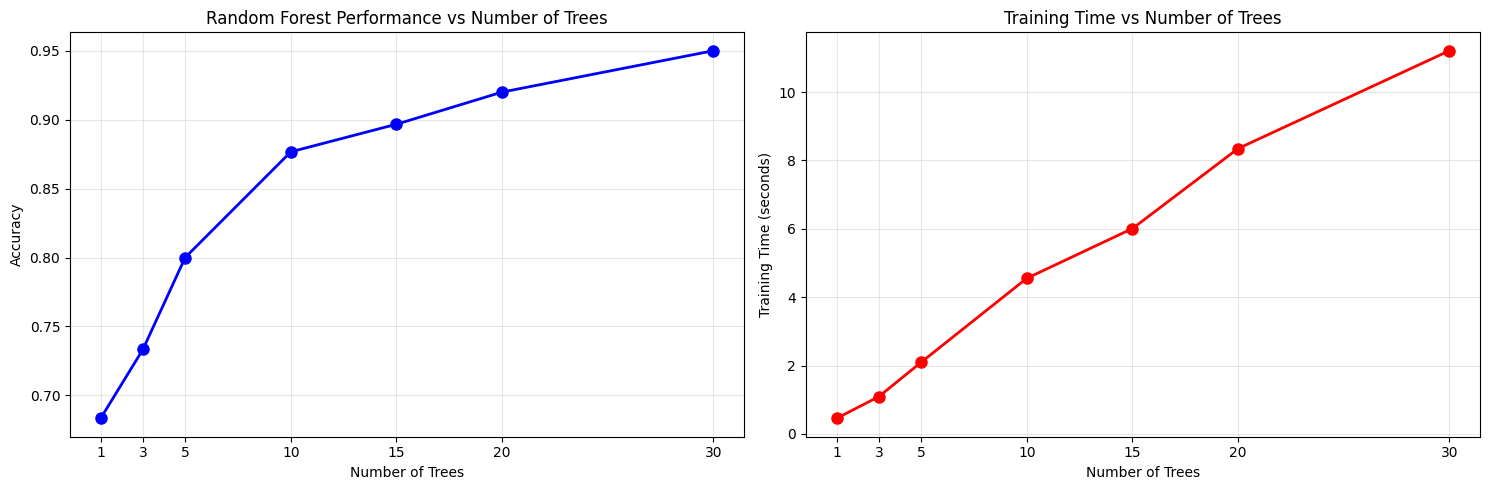


Best number of trees: 30 with accuracy: 0.9500


In [10]:
# Test different numbers of trees
n_trees_values = [1, 3, 5, 10, 15, 20, 30]
accuracies = []
training_times = []

print("Testing different numbers of trees...\n")

for n_trees in n_trees_values:
    print(f"Testing n_trees={n_trees}...")
    
    start_time = time.time()
    
    # Build Random Forest classifier
    net = build_random_forest_classifier(n_trees=n_trees, max_depth=6, num_classes=10)
    net.data_layer = digitdata
    
    # Store training data in the Random Forest layer
    rf_layer = net.layers[1]
    rf_layer.store_training_data(train_subset, labels_subset)
    
    training_time = time.time() - start_time
    training_times.append(training_time)
    
    # Test on a subset for faster computation
    test_subset_size = 300
    test_indices = np.random.choice(len(test_data), test_subset_size, replace=False)
    test_subset = test_data[test_indices]
    test_labels_subset = test_labels[test_indices]
    
    # Predict
    predictions = net.test(test_subset)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == test_labels_subset)
    accuracies.append(accuracy)
    
    print(f"  Accuracy: {accuracy:.4f}, Training time: {training_time:.2f}s")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs number of trees
ax1.plot(n_trees_values, accuracies, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Accuracy')
ax1.set_title('Random Forest Performance vs Number of Trees')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_trees_values)

# Training time vs number of trees
ax2.plot(n_trees_values, training_times, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time vs Number of Trees')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(n_trees_values)

plt.tight_layout()
plt.show()

# Find and print best number of trees
best_idx = np.argmax(accuracies)
best_n_trees = n_trees_values[best_idx]
best_acc = accuracies[best_idx]

print(f"\nBest number of trees: {best_n_trees} with accuracy: {best_acc:.4f}")

### Analysis with Different Tree Depths

Testing different tree depths...

Testing max_depth=2...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.4950
Testing max_depth=3...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.7150
Testing max_depth=4...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.8650
Testing max_depth=5...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.9150
Testing max_depth=6...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.9450
Testing max_depth=8...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.9650
Testing max_depth=10...
Training Random Forest with 1000 training samples...
Trained 30 trees successfully
  Accuracy: 0.9750


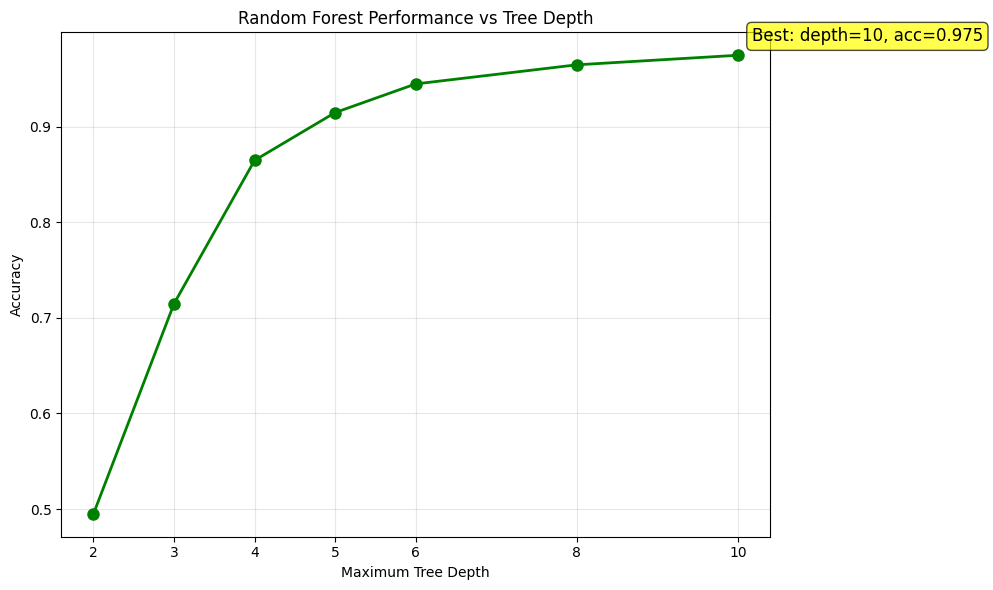


Best tree depth: 10 with accuracy: 0.9750


In [11]:
# Test different tree depths
max_depth_values = [2, 3, 4, 5, 6, 8, 10]
depth_accuracies = []

print("Testing different tree depths...\n")

for max_depth in max_depth_values:
    print(f"Testing max_depth={max_depth}...")
    
    # Build Random Forest classifier
    net = build_random_forest_classifier(n_trees=best_n_trees, max_depth=max_depth, num_classes=10)
    
    # Store training data in the Random Forest layer
    rf_layer = net.layers[1]
    rf_layer.store_training_data(train_subset, labels_subset)
    
    # Test on a subset for faster computation
    test_subset_size = 200
    test_indices = np.random.choice(len(test_data), test_subset_size, replace=False)
    test_subset = test_data[test_indices]
    test_labels_subset = test_labels[test_indices]
    
    # Predict
    predictions = net.test(test_subset)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == test_labels_subset)
    depth_accuracies.append(accuracy)
    
    print(f"  Accuracy: {accuracy:.4f}")

# Plot depth analysis
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, depth_accuracies, 'go-', linewidth=2, markersize=8)
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance vs Tree Depth')
plt.grid(True, alpha=0.3)
plt.xticks(max_depth_values)

# Find and annotate best depth
best_depth_idx = np.argmax(depth_accuracies)
best_depth = max_depth_values[best_depth_idx]
best_depth_acc = depth_accuracies[best_depth_idx]
plt.annotate(f'Best: depth={best_depth}, acc={best_depth_acc:.3f}', 
            xy=(best_depth, best_depth_acc), xytext=(10, 10),
            textcoords='offset points', fontsize=12,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nBest tree depth: {best_depth} with accuracy: {best_depth_acc:.4f}")

### Visualize Some Predictions

Training Random Forest with 1000 training samples...
Trained 30 trees successfully


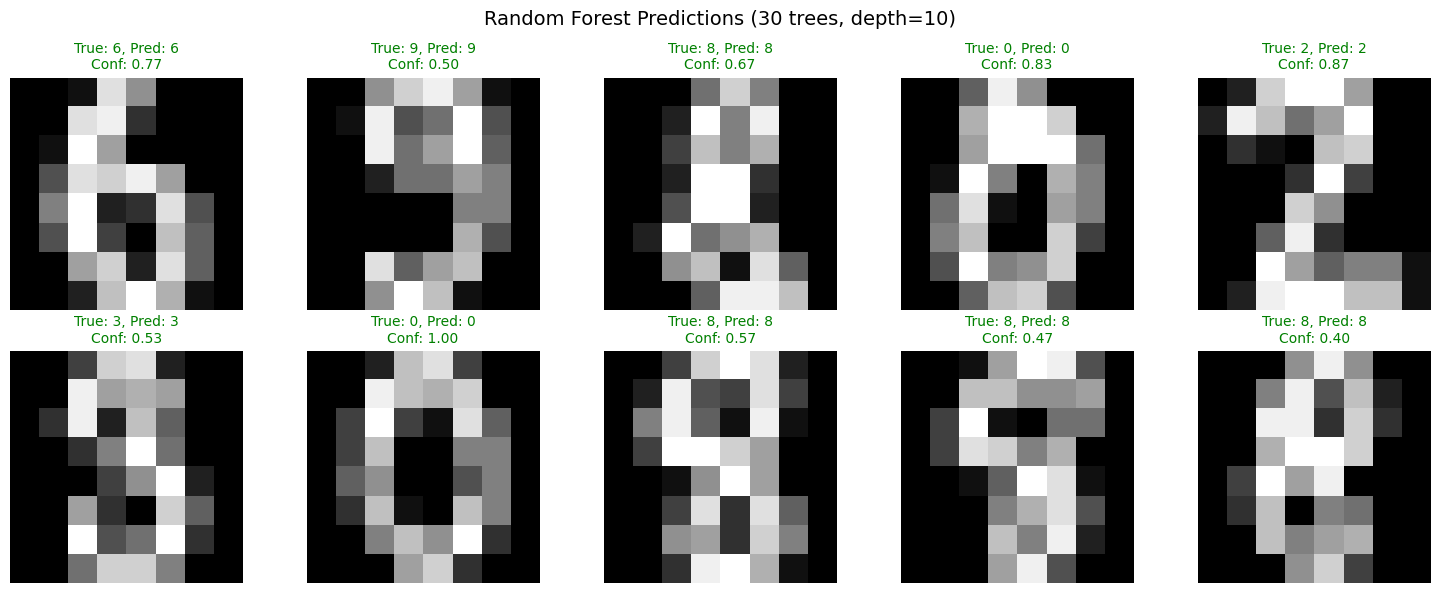

In [12]:
# Use the best parameters for final predictions
final_net = build_random_forest_classifier(n_trees=best_n_trees, max_depth=best_depth, num_classes=10)
final_net.data_layer = digitdata
rf_layer = final_net.layers[1]
rf_layer.store_training_data(train_subset, labels_subset)

# Get some test samples for visualization
n_samples = 10
sample_indices = np.random.choice(len(test_data), n_samples, replace=False)
sample_data = test_data[sample_indices]
sample_labels = test_labels[sample_indices]

# Make predictions
sample_predictions = final_net.test(sample_data)
sample_predicted_classes = np.argmax(sample_predictions, axis=1)

# Visualize results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(n_samples):
    row, col = i // 5, i % 5
    
    # Show image
    axes[row, col].imshow(sample_data[i].reshape(8, 8), cmap='gray')
    
    # Set title with true and predicted labels
    true_label = int(sample_labels[i])
    pred_label = sample_predicted_classes[i]
    confidence = sample_predictions[i, pred_label]
    
    color = 'green' if true_label == pred_label else 'red'
    axes[row, col].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}', 
                            color=color, fontsize=10)
    axes[row, col].axis('off')

plt.suptitle(f'Random Forest Predictions ({best_n_trees} trees, depth={best_depth})', fontsize=14)
plt.tight_layout()
plt.show()

### Feature Importance Analysis

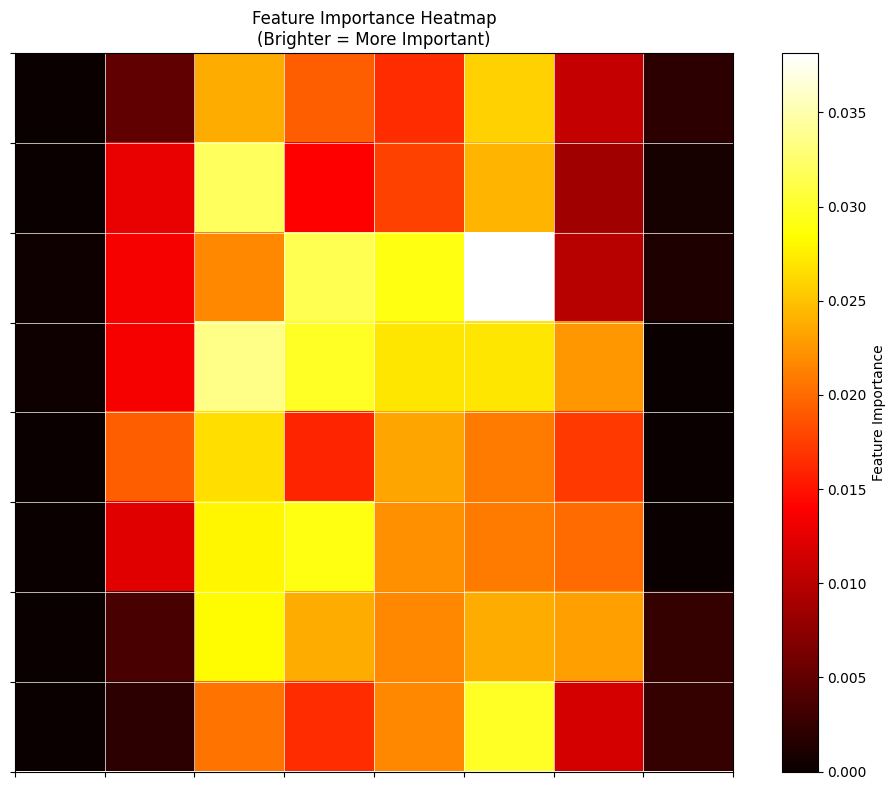


Top 10 most important features (pixel positions):
 1. Pixel (2,5) - Importance: 0.0381
 2. Pixel (3,2) - Importance: 0.0336
 3. Pixel (1,2) - Importance: 0.0320
 4. Pixel (2,3) - Importance: 0.0316
 5. Pixel (7,5) - Importance: 0.0299
 6. Pixel (3,3) - Importance: 0.0299
 7. Pixel (2,4) - Importance: 0.0291
 8. Pixel (5,3) - Importance: 0.0291
 9. Pixel (6,2) - Importance: 0.0283
10. Pixel (5,2) - Importance: 0.0279


In [13]:
# Get feature importance from the trained Random Forest
feature_importance = rf_layer.get_feature_importance()

if feature_importance is not None:
    # Reshape importance to match image dimensions (8x8)
    importance_image = feature_importance.reshape(8, 8)
    
    # Plot feature importance as heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(importance_image, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Feature Importance')
    plt.title('Feature Importance Heatmap\n(Brighter = More Important)')
    
    # Add grid to show pixel boundaries
    plt.xticks(np.arange(-0.5, 8, 1), [])
    plt.yticks(np.arange(-0.5, 8, 1), [])
    plt.grid(True, color='white', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Show top 10 most important features
    top_features = np.argsort(feature_importance)[-10:][::-1]
    print("\nTop 10 most important features (pixel positions):")
    for i, feature_idx in enumerate(top_features, 1):
        row, col = feature_idx // 8, feature_idx % 8
        print(f"{i:2d}. Pixel ({row},{col}) - Importance: {feature_importance[feature_idx]:.4f}")
else:
    print("Feature importance not available")

### Error Analysis

Number of misclassified samples: 15 out of 360
Error rate: 4.17%


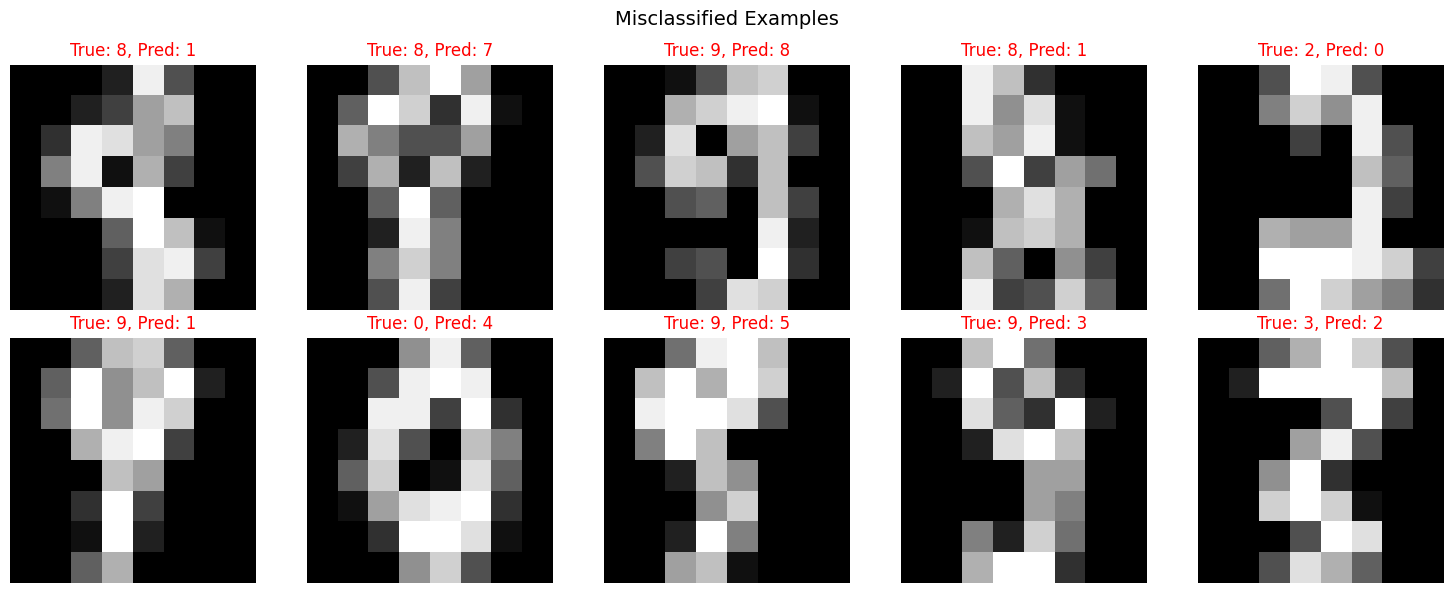

In [14]:
# Find misclassified samples
final_predictions = final_net.test(test_data)
final_predicted_classes = np.argmax(final_predictions, axis=1)
misclassified_indices = np.where(final_predicted_classes != test_labels)[0]

print(f"Number of misclassified samples: {len(misclassified_indices)} out of {len(test_labels)}")
print(f"Error rate: {len(misclassified_indices) / len(test_labels) * 100:.2f}%")

# Show some misclassified examples
n_examples = min(10, len(misclassified_indices))
if n_examples > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i in range(n_examples):
        idx = misclassified_indices[i]
        row, col = i // 5, i % 5
        
        axes[row, col].imshow(test_data[idx].reshape(8, 8), cmap='gray')
        axes[row, col].set_title(f'True: {int(test_labels[idx])}, Pred: {final_predicted_classes[idx]}', 
                                color='red')
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(n_examples, 10):
        row, col = i // 5, i % 5
        axes[row, col].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples to show!")

### Same with CIFAR


dataset Informations:
--------------------------------------------------
Training samples: 39000
Sample shape: (3, 32, 32)
Number of classes: 10
Test samples: 12000
Dataset size in memory: 597.66 MB


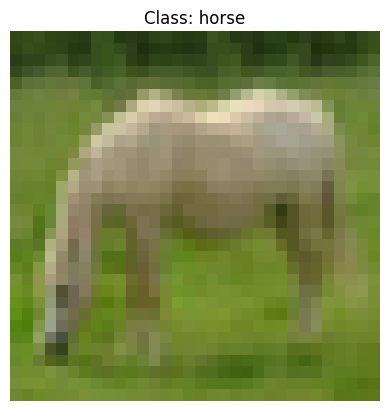

Created Random Forest model for CIFAR
Training Random Forest on CIFAR data...
Training Random Forest with 800 training samples...
Trained 30 trees successfully

On the CIFAR dataset, Random Forest achieves an accuracy of: 25.00%


In [15]:
# Test on CIFAR dataset
cifar = DatasetClasses.CifarData(100)
cifar.print_dataset_info()

# Build Random Forest for CIFAR
cifar_net = build_random_forest_classifier(n_trees=best_n_trees, max_depth=best_depth, num_classes=10)
cifar_net.data_layer = cifar
print("Created Random Forest model for CIFAR")

# Get CIFAR training data
cifar_train_data, cifar_train_labels_onehot = cifar.get_train_set()
cifar_train_labels = np.argmax(cifar_train_labels_onehot, axis=1)
cifar_rf_layer = cifar_net.layers[1]

# Use smaller subset for CIFAR (higher dimensional)
cifar_subset_size = 800
cifar_indices = np.random.choice(len(cifar_train_data), cifar_subset_size, replace=False)
cifar_train_subset = cifar_train_data[cifar_indices].reshape(cifar_subset_size, -1)
cifar_labels_subset = cifar_train_labels[cifar_indices]

print("Training Random Forest on CIFAR data...")
cifar_rf_layer.store_training_data(cifar_train_subset, cifar_labels_subset)

# Test on CIFAR test set (subset)
cifar_test_data, cifar_test_labels_onehot = cifar.get_test_set()
cifar_test_labels = np.argmax(cifar_test_labels_onehot, axis=1)
cifar_test_subset_size = 200
cifar_test_indices = np.random.choice(len(cifar_test_data), cifar_test_subset_size, replace=False)
cifar_test_subset = cifar_test_data[cifar_test_indices]
cifar_test_labels_subset = cifar_test_labels[cifar_test_indices]

# Test the network
cifar_results = cifar_net.test(cifar_test_subset)
cifar_predicted_classes = np.argmax(cifar_results, axis=1)
cifar_accuracy = np.mean(cifar_predicted_classes == cifar_test_labels_subset)

print(f'\nOn the CIFAR dataset, Random Forest achieves an accuracy of: {cifar_accuracy * 100:.2f}%')

%25% on CIFAR